In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

import yaml

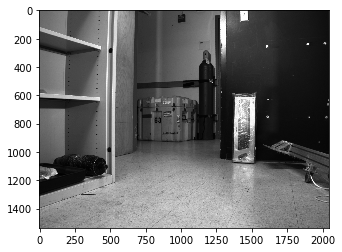

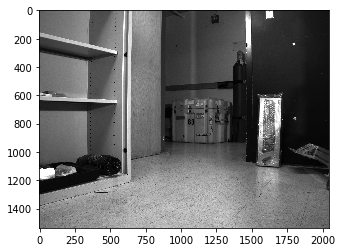

In [4]:

imgL = cv2.imread('images/left_raw.png')
imgRmono = cv2.imread('images/right_raw.png')

imgLmono = cv2.cvtColor(imgL, cv2.COLOR_RGB2GRAY)

plt.imshow(imgLmono, cmap="gray")
plt.show()

plt.imshow(imgRmono)
plt.show()

In [21]:
import pprint as pp

def mat_from_dict( d ):
    return np.reshape( d['data'], (d['rows'], d['cols'] ) )

def cam_from_yaml( y ):
    return { 'size': (y['image_width'], y['image_height']),
             'K': mat_from_dict( y['camera_matrix'] ),
             'dist': mat_from_dict( y['distortion_coefficients']),
             'projection': mat_from_dict( y['projection_matrix']),
             'rectification': mat_from_dict( y['rectification_matrix'])}

with open("camera_info/18457940.yaml") as f:
    y = yaml.load(f, Loader=yaml.SafeLoader)
    leftCam = cam_from_yaml( y )
    
with open("camera_info/18296567.yaml") as f:
    y = yaml.load(f, Loader=yaml.SafeLoader)
    rightCam = cam_from_yaml(y)
    
pp.pprint(leftCam)
    
    

{'K': array([[1.83874190e+03, 0.00000000e+00, 1.03742237e+03],
       [0.00000000e+00, 1.83567452e+03, 7.39303998e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'dist': array([[-0.176484,  0.104623, -0.00046 ,  0.000468,  0.      ]]),
 'projection': array([[-1.29929126e+03,  0.00000000e+00,  1.07792867e+03,
         1.97020303e+02],
       [ 0.00000000e+00, -1.29929126e+03,  8.04322227e+02,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00]]),
 'rectification': array([[-9.93993e-01,  4.35000e-03, -1.09361e-01],
       [-4.39300e-03, -9.99990e-01,  1.51000e-04],
       [-1.09359e-01,  6.31000e-04,  9.94002e-01]]),
 'size': (2048, 1536)}


## Undistort

In [ ]:
rectify_scale = 0 # 0=full crop, 1=no crop

R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(data["cameraMatrix1"], data["distCoeffs1"], data["cameraMatrix2"], data["distCoeffs2"], (640, 480), data["R"], data["T"], alpha = rectify_scale)
left_maps = cv2.initUndistortRectifyMap(data["cameraMatrix1"], data["distCoeffs1"], R1, P1, (640, 480), cv2.CV_16SC2)
right_maps = cv2.initUndistortRectifyMap(data["cameraMatrix2"], data["distCoeffs2"], R2, P2, (640, 480), cv2.CV_16SC2)
 
for pair in pairs:
    left_img_remap = cv2.remap(pair.left_img, left_maps[0], left_maps[1], cv2.INTER_LANCZOS4)
    right_img_remap = cv2.remap(pair.right_img, right_maps[0], right_maps[1], cv2.INTER_LANCZOS4)


In [ ]:
stereo = cv2.createStereoBM(numDisparities=16, blockSize=15)
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')
plt.show()